In [1]:
!date

Thu Mar  5 22:44:09 PST 2020


# Compare good vs bad GENE level quantification

In [3]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

def nd(arr):
    return np.asarray(arr).reshape(-1)

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [4]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [5]:
good = pd.read_csv("tables/union_test_subclass_DE.csv", index_col=0)
bad = pd.read_csv("tables/union_test_subclass_DE_bad.csv", index_col=0)

In [8]:
gene_good = anndata.read_h5ad("../cell_ranger_annotation/no_filter_gene.h5ad")
gene_bad = anndata.read_h5ad("../cell_ranger_annotation/bad_gene.h5ad")

In [24]:
good.groupby("index")['gene_name'].count()

index
Astro             0
Endo             47
L2/3 IT        3664
L5 IT          3384
L5 PT           255
L5/6 NP        1099
L6 CT          2015
L6 IT          2320
L6 IT Car3       14
L6b            2793
Lamp5           563
Low Quality      69
Pvalb          1426
SMC              80
Sncg            637
Sst             877
VLMC              6
Vip             376
Name: gene_name, dtype: int64

In [25]:
bad.groupby("index")['gene_name'].count()

index
Astro             0
Endo             53
L2/3 IT        3788
L5 IT          3319
L5 PT           397
L5/6 NP        1004
L6 CT          2139
L6 IT          2556
L6 IT Car3       19
L6b            2820
Lamp5           582
Low Quality      76
Pvalb          1529
SMC              82
Sncg            642
Sst             932
VLMC              6
Vip             374
Name: gene_name, dtype: int64

In [26]:
specific_cluster = "Pvalb"

In [157]:
good.index = good["index"] + "_" + good["gene_name"]
bad.index = bad["index"] + "_" + bad["gene_name"]

In [163]:
fn = np.setdiff1d(good.index.values[1:], bad.index.values[1:])
fp = np.setdiff1d(bad.index.values[1:], good.index.values[1:])

# False positive

In [203]:
bad.loc[fp].sort_values("p_raw")

,index,gene_name,p_raw,p_bonferroni
L2/3 IT_Atp2b4_ENSMUSG00000026463,L2/3 IT,Atp2b4_ENSMUSG00000026463,9.528168e-137,1.479391e-132
L6 IT_Atp2b4_ENSMUSG00000026463,L6 IT,Atp2b4_ENSMUSG00000026463,1.649130e-111,2.560522e-107
L6b_Nrxn1_ENSMUSG00000024109,L6b,Nrxn1_ENSMUSG00000024109,4.663533e-80,7.240834e-76
L6 IT_Smarca2_ENSMUSG00000024921,L6 IT,Smarca2_ENSMUSG00000024921,2.668749e-35,4.143633e-31
Pvalb_Camta1_ENSMUSG00000014592,Pvalb,Camta1_ENSMUSG00000014592,1.636207e-33,2.540456e-29
...,...,...,...,...
L6 CT_Zc3h14_ENSMUSG00000021012,L6 CT,Zc3h14_ENSMUSG00000021012,6.379451e-07,9.905055e-03
L6 CT_Bex2_ENSMUSG00000042750,L6 CT,Bex2_ENSMUSG00000042750,6.391232e-07,9.923347e-03
L6 CT_Tspan13_ENSMUSG00000020577,L6 CT,Tspan13_ENSMUSG00000020577,6.424446e-07,9.974916e-03
L5 PT_Rabepk_ENSMUSG00000070953,L5 PT,Rabepk_ENSMUSG00000070953,6.427094e-07,9.979028e-03


In [264]:
specific_cluster = "L6b"
specific_gene = "Nrxn1_ENSMUSG00000024109"

In [265]:
specific_gene

'Nrxn1_ENSMUSG00000024109'

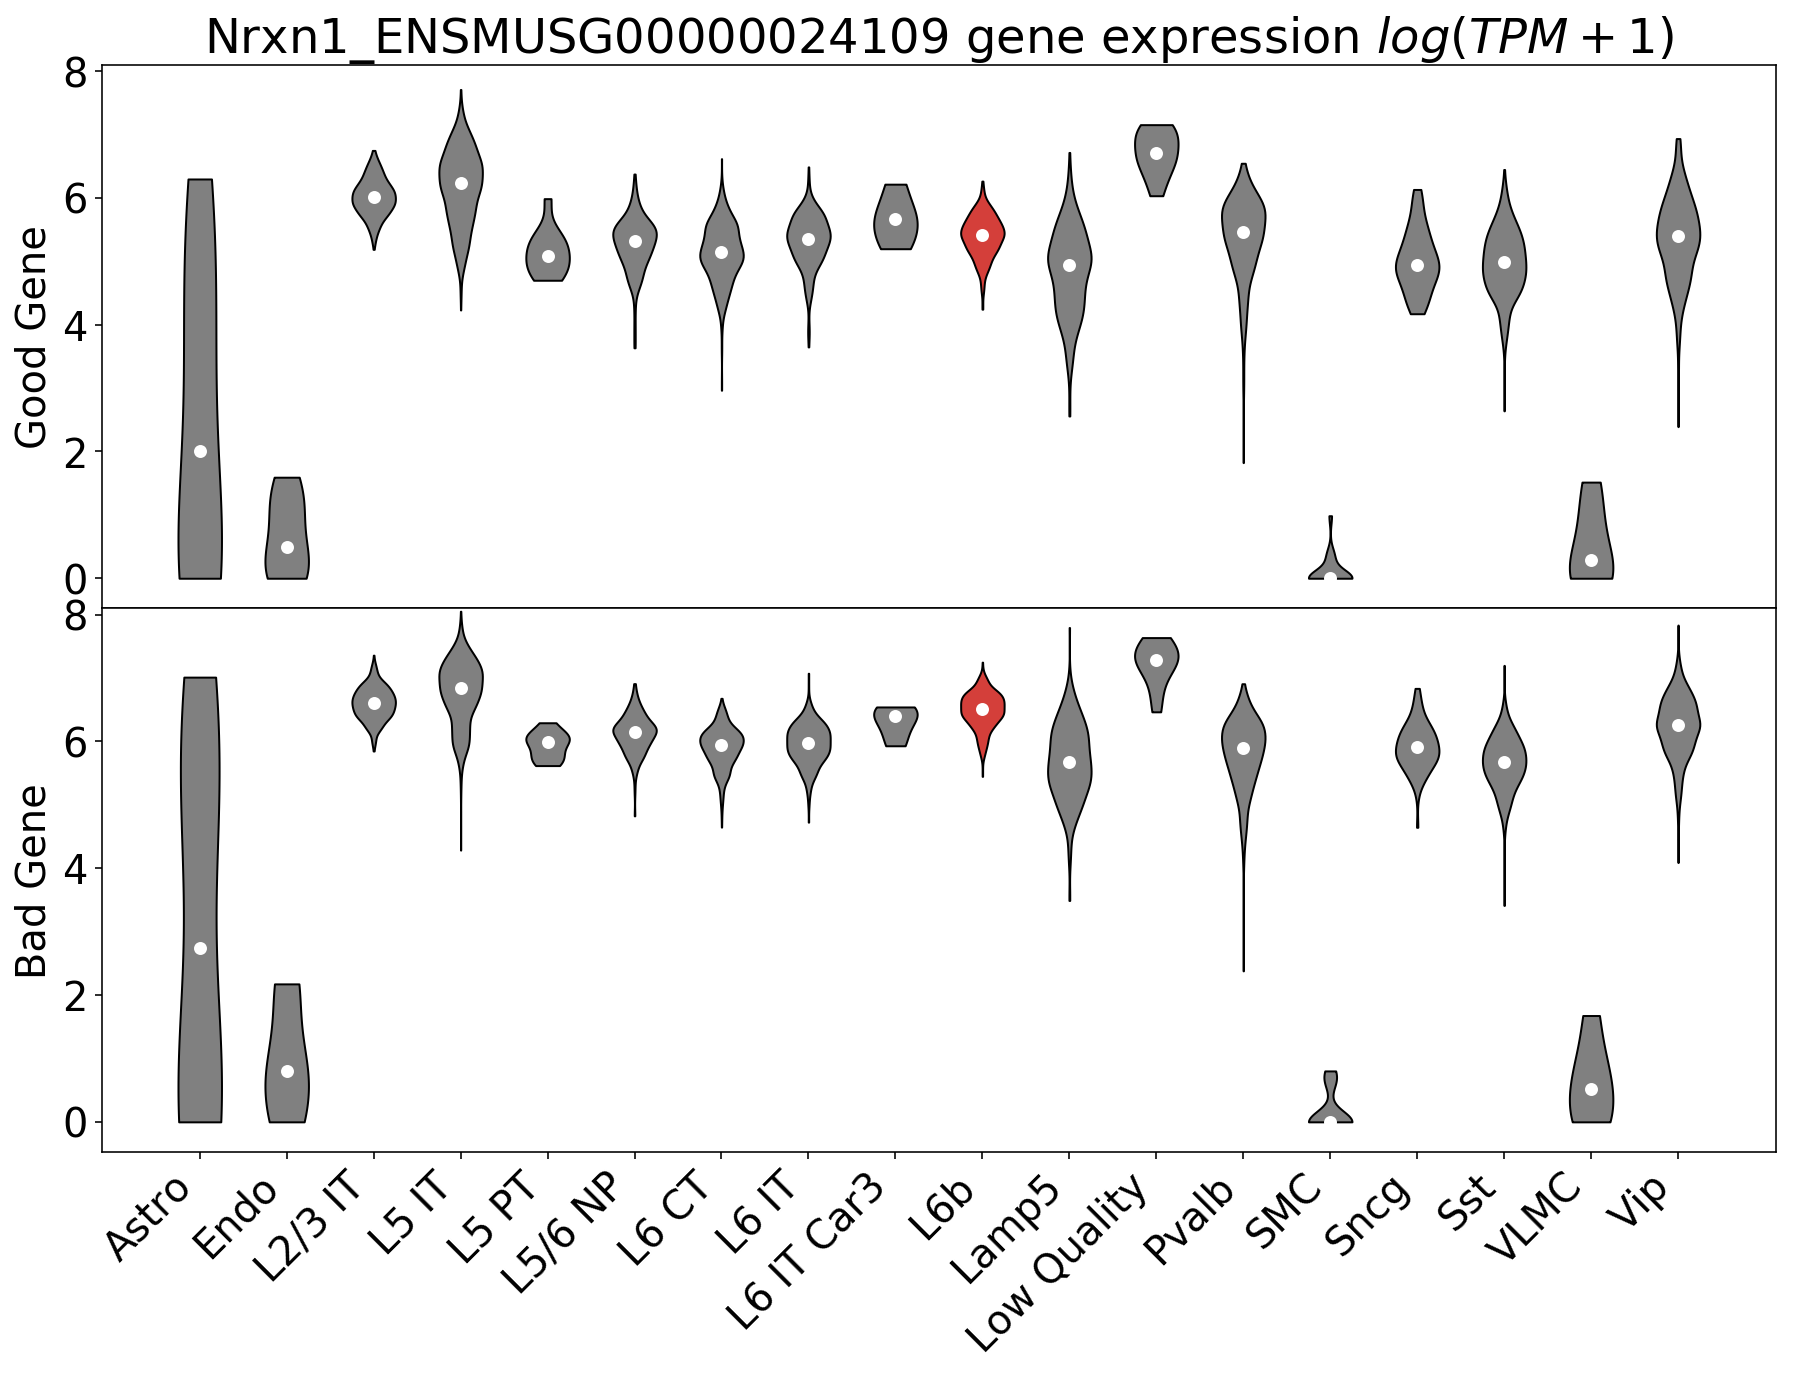

In [266]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2)
fig.subplots_adjust(hspace=0, wspace=0)

unique = np.unique(gene_good.obs.subclass_label.values)


labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]
#######3# Gene
x = []
for c in unique:
    x.append(np.asarray(gene_good[gene_good.obs.subclass_label==c][:,gene_good.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

parts = ax[0].violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor("#D43F3A")

medians = [np.median(i) for i in x]
ax[0].scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)

#ax[0].axhline(y=medians[midx], color="k", linestyle="--")
ax[0].set_ylabel("Good Gene")


medians = [np.median(i) for i in x]
ax[0].set_xticks(lidx)
ax[0].set_xticklabels(labels, rotation=45, ha="right")
ax[0].set_title("{} gene expression $log(TPM + 1)$".format(specific_gene))


#################### BAD GENE ####################


x = []
for c in unique:
    x.append(np.asarray(gene_bad[gene_bad.obs.subclass_label==c][:,gene_bad.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

parts = ax[1].violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor("#D43F3A")

medians = [np.median(i) for i in x]
ax[1].scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)

#ax[0].axhline(y=medians[midx], color="k", linestyle="--")
ax[1].set_ylabel("Bad Gene")


medians = [np.median(i) for i in x]
ax[1].set_xticks(lidx)
ax[1].set_xticklabels(labels, rotation=45, ha="right")
ax[1].set_ylim(ax[0].get_ylim())




#plt.savefig("./figures/class_DE_violin_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [267]:
def yex(ax):
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

In [268]:
specific_cluster

'L6b'

In [269]:
mtx_good = nd(gene_good.layers["log1p"].todense()[:,gene_good.var.gene_name==specific_gene])
mtx_bad = nd(gene_bad.layers["log1p"].todense()[:,gene_good.var.gene_name==specific_gene])

In [270]:
unique = np.unique(gene_good.obs.subclass_label)

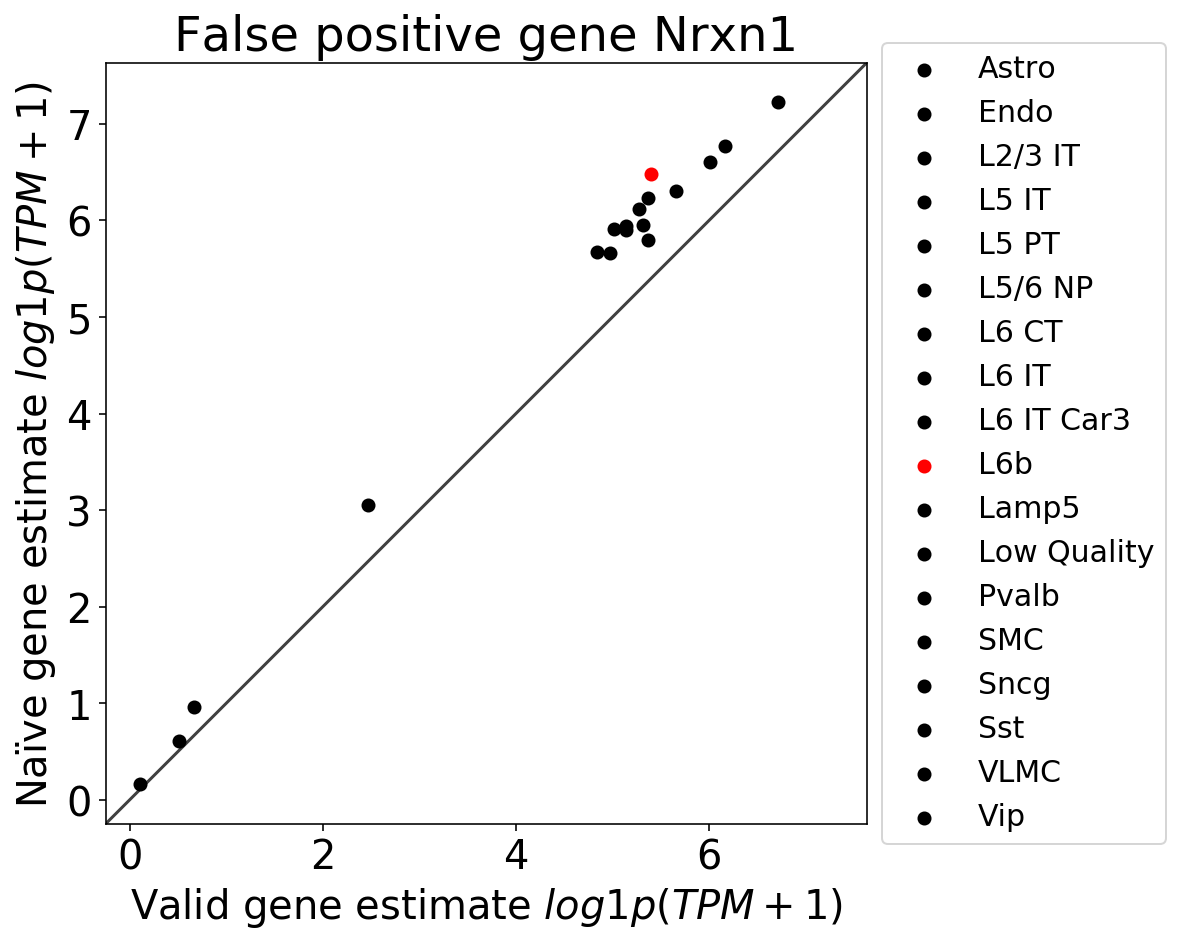

In [271]:
fig, ax = plt.subplots(figsize=(7,7))

ax.set_title("False positive gene {}".format(specific_gene.split("_")[0]))


x = []
y = []

for c in unique:
    x.append(nd(mtx_good[gene_good.obs.subclass_label==c].mean(axis=0)))
    y.append(nd(mtx_bad[gene_bad.obs.subclass_label==c].mean(axis=0)))

for cidx, c in enumerate(unique):
    color="black"
    if c == specific_cluster: color="red"
    ax.scatter(x[cidx], y[cidx], label="{}".format(c), color=color)
ax.set_xlim(0)
yex(ax)
ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5), fontsize=fsize-5)
ax.set_xlabel("Valid gene estimate $log1p(TPM +1)$")
ax.set_ylabel("Naïve gene estimate $log1p(TPM+1)$")

plt.savefig("./figures/false_positive_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)

plt.show()


# False Negative

In [205]:
good.loc[fn].sort_values("p_raw")

,index,gene_name,p_raw,p_bonferroni
L5 IT_Nptn_ENSMUSG00000032336,L5 IT,Nptn_ENSMUSG00000032336,4.069605e-33,6.318672e-29
L6 CT_Zfp729a_ENSMUSG00000021510,L6 CT,Zfp729a_ENSMUSG00000021510,5.064686e-33,7.863684e-29
Pvalb_Pafah1b1_ENSMUSG00000020745,Pvalb,Pafah1b1_ENSMUSG00000020745,8.439037e-28,1.310287e-23
L2/3 IT_Camta1_ENSMUSG00000014592,L2/3 IT,Camta1_ENSMUSG00000014592,1.610066e-26,2.499870e-22
L6 IT_Rab11a_ENSMUSG00000004771,L6 IT,Rab11a_ENSMUSG00000004771,8.217935e-22,1.275958e-17
...,...,...,...,...
L6b_Ndufaf8_ENSMUSG00000078572,L6b,Ndufaf8_ENSMUSG00000078572,6.387116e-07,9.916956e-03
Lamp5_Atp2c1_ENSMUSG00000032570,Lamp5,Atp2c1_ENSMUSG00000032570,6.392806e-07,9.925791e-03
L5 PT_Nipsnap2_ENSMUSG00000029432,L5 PT,Nipsnap2_ENSMUSG00000029432,6.393381e-07,9.926683e-03
L2/3 IT_Cystm1_ENSMUSG00000046727,L2/3 IT,Cystm1_ENSMUSG00000046727,6.395063e-07,9.929295e-03


In [223]:
specific_cluster = "L6 CT" 
specific_gene = "Zfp729a_ENSMUSG00000021510"

In [224]:
specific_gene

'Zfp729a_ENSMUSG00000021510'

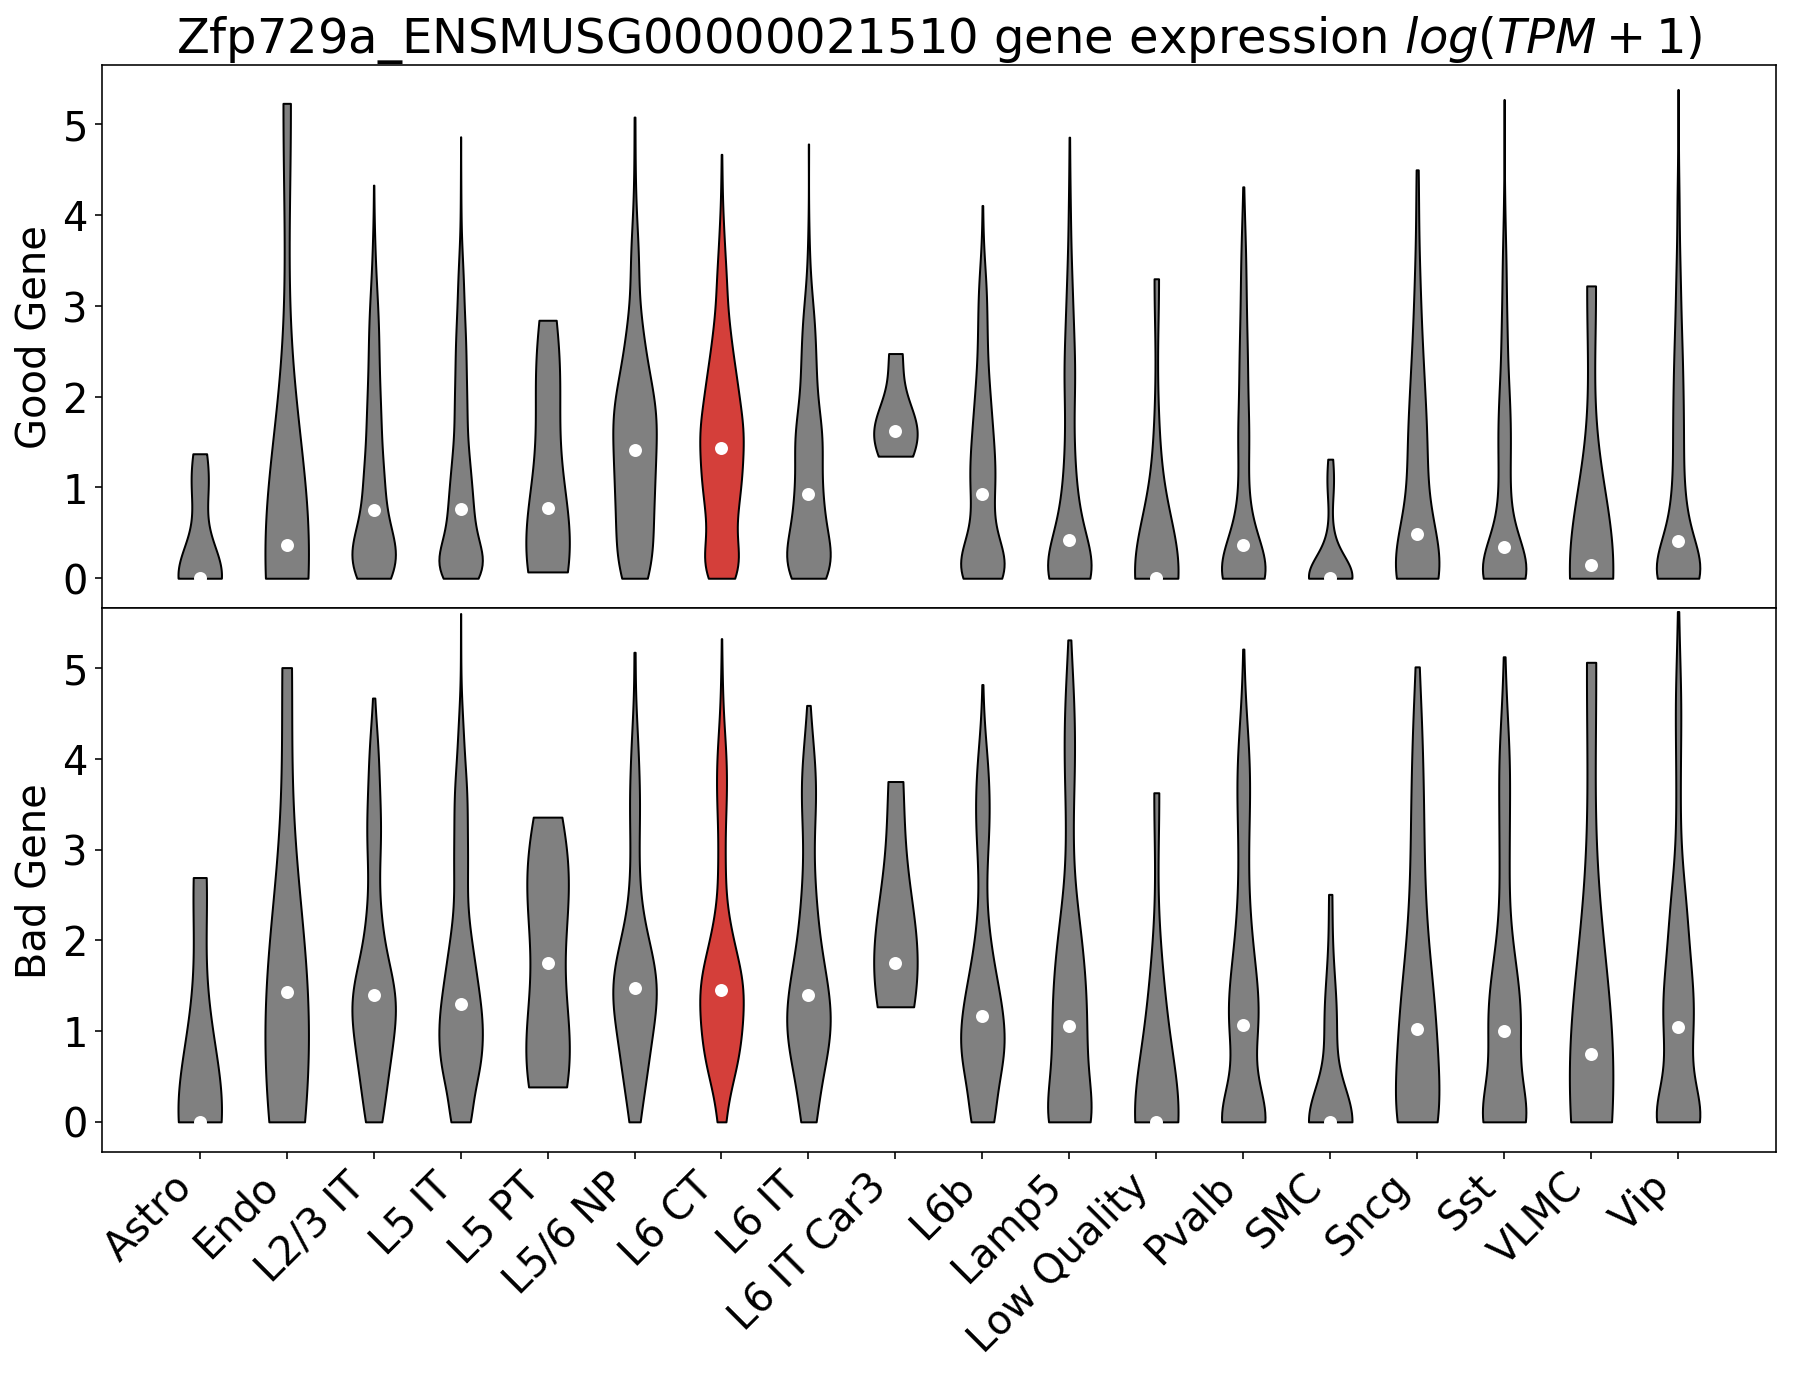

In [225]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2)
fig.subplots_adjust(hspace=0, wspace=0)

unique = np.unique(gene_good.obs.subclass_label.values)


labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]
#######3# Gene
x = []
for c in unique:
    x.append(np.asarray(gene_good[gene_good.obs.subclass_label==c][:,gene_good.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

parts = ax[0].violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor("#D43F3A")

medians = [np.median(i) for i in x]
ax[0].scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)

#ax[0].axhline(y=medians[midx], color="k", linestyle="--")
ax[0].set_ylabel("Good Gene")


medians = [np.median(i) for i in x]
ax[0].set_xticks(lidx)
ax[0].set_xticklabels(labels, rotation=45, ha="right")
ax[0].set_title("{} gene expression $log(TPM + 1)$".format(specific_gene))


#################### BAD GENE ####################


x = []
for c in unique:
    x.append(np.asarray(gene_bad[gene_bad.obs.subclass_label==c][:,gene_bad.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

parts = ax[1].violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor("#D43F3A")

medians = [np.median(i) for i in x]
ax[1].scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)

#ax[0].axhline(y=medians[midx], color="k", linestyle="--")
ax[1].set_ylabel("Bad Gene")


medians = [np.median(i) for i in x]
ax[1].set_xticks(lidx)
ax[1].set_xticklabels(labels, rotation=45, ha="right")
ax[1].set_ylim(ax[0].get_ylim())




#plt.savefig("./figures/class_DE_violin_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [226]:
def yex(ax):
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

In [227]:
specific_cluster

'L6 CT'

In [228]:
mtx_good = nd(gene_good.layers["log1p"].todense()[:,gene_good.var.gene_name==specific_gene])
mtx_bad = nd(gene_bad.layers["log1p"].todense()[:,gene_good.var.gene_name==specific_gene])

In [229]:
unique = np.unique(gene_good.obs.subclass_label)

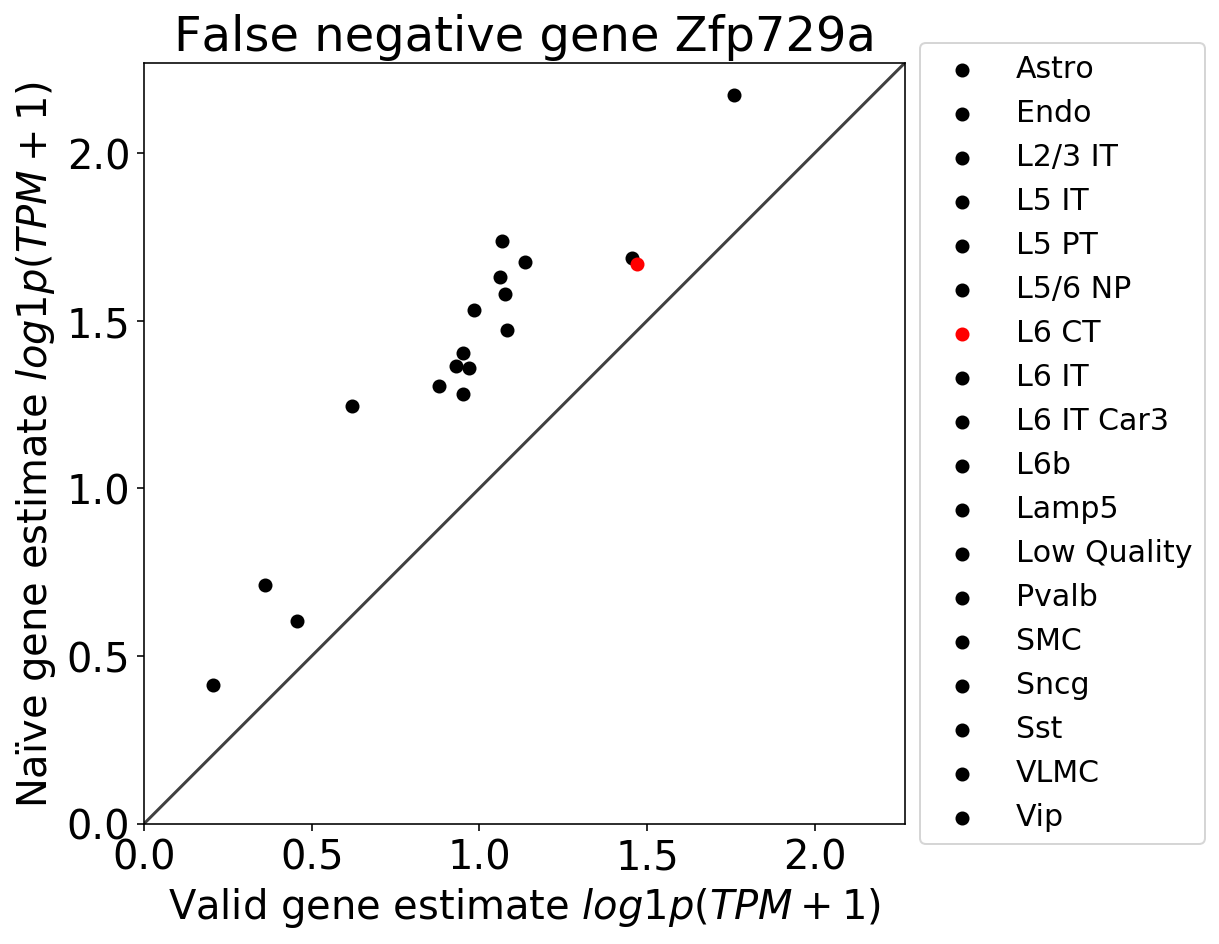

In [235]:
fig, ax = plt.subplots(figsize=(7,7))

ax.set_title("False negative gene {}".format(specific_gene.split("_")[0]))


x = []
y = []

for c in unique:
    x.append(nd(mtx_good[gene_good.obs.subclass_label==c].mean(axis=0)))
    y.append(nd(mtx_bad[gene_bad.obs.subclass_label==c].mean(axis=0)))

for cidx, c in enumerate(unique):
    color="black"
    if c == specific_cluster: color="red"
    ax.scatter(x[cidx], y[cidx], label="{}".format(c), color=color)
ax.set_xlim(0)
yex(ax)
ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5), fontsize=fsize-5)
ax.set_xlabel("Valid gene estimate $log1p(TPM +1)$")
ax.set_ylabel("Naïve gene estimate $log1p(TPM+1)$")


plt.savefig("./figures/false_negative_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)


plt.show()
